# Práctica 6.3. Uso avanzados de Redes Recurrentes

In [ ]:
import keras
keras.__version__

## 1. Uso avanzado de redes neuronales recurrentes


En esta práctica, revisaremos tres técnicas avanzadas para mejorar el rendimiento y el poder de generalización de las redes de neuronas recurrentes. Al final de la práctica, sabrás la mayor parte de lo que hay que saber sobre el uso de redes recurrentes con Keras. Vamos a mostrar los tres conceptos sobre un problema de pronóstico del tiempo, donde tenemos acceso a una serie de puntos de datos provenientes de los sensores instalados en el techo de un edificio, como la temperatura, la presión del aire y la humedad, que utilizamos para predecir cuál será la temperaturam24 horas después del último punto de datos recogido. Este es un problema bastante difícil que ejemplifica muchas de las dificultades comunes encontradas cuando se trabaja con series temporales.

Cubriremos las siguientes técnicas:

* *Recurrent dropout*, una forma específica e incorporada de utilizar la función de dropout para luchar contra el sobreajuste en capas recurrentes.
* *Stacking recurrent layers*, para aumentar la capacidad de representación de la red (a costa de mayores cargas computacionales).
* *Bidirectional recurrent layers*, que presenta la misma información a una red recurrente de diferentes maneras, aumentando la precisión y mitigando los problemas de olvido.

## 2. Un problema de pronóstico de temperatura

Hasta ahora, los únicos datos de secuencia que hemos cubierto han sido los datos de texto, por ejemplo, el conjunto de datos IMDB y el conjunto de datos de Reuters. Pero las secuencias de datos se encuentran en muchos más problemas que sólo el procesamiento del lenguaje. En todos los ejemplos de esta práctica, jugaremos con un tiempo 
registrado en la Estación Meteorológica del Instituto Max-Planck de Biogeoquímica de Jena, Alemania: 
http://www.bgc-jena.mpg.de/wetter/.

En este conjunto de datos, se registran catorce cantidades diferentes (como la temperatura del aire, la presión atmosférica, la humedad, la dirección del viento, etc.) cada diez minutos, durante varios años. Los datos originales se remontan a 2003, pero nos limitamos a los datos de 2009-2016. Puedes encontrar los datos en Kaggle. Este conjunto de datos es perfecto para aprender a trabajar con series temporales numéricas. Lo usaremos para construir un modelo que tome como entrada algunos datos del pasado reciente (una días de puntos de datos) y predice la temperatura del aire en 24 horas en el futuro.

Echemos un vistazo a los datos:

In [28]:
import os

data_dir = '../../data/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Convirtamos todas estas 420.551 líneas de datos en una matriz Numpy:

In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Por ejemplo, aquí está el gráfico de la temperatura (en grados centígrados) a lo largo del tiempo:

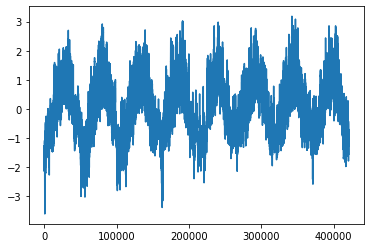

In [26]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperatura (en grados celsius)
plt.plot(range(len(temp)), temp)
plt.show()

En este gráfico se puede ver claramente la periodicidad anual de la temperatura.

Aquí hay un gráfico más refinado de los primeros diez días de datos de temperatura (ya que los datos se registran cada diez minutos, obtenemos 144 puntos de datos por día):

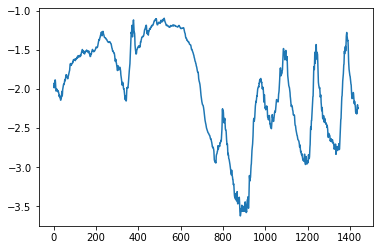

In [27]:
plt.plot(range(1440), temp[:1440])
plt.show()

En esta gráfica se puede ver la periodicidad diaria, especialmente la de los últimos 4 días. También podemos notar que este período de diez días debe venir de un mes de invierno bastante frío.

Si estuviéramos tratando de predecir la temperatura media para el mes siguiente dados unos pocos datos del pasado, el problema sería fácil, debido a la periodicidad fiable de los datos a escala anual. Pero mirando los datos en una escala de días, la temperatura parece mucho más caótica. Por tanto, ¿son estas series temporales predecibles a escala diaria? Vamos a averiguarlo.

## 3. Preparando los datos

La formulación exacta de nuestro problema será la siguiente: dados los datos que se remontan a `lookback` pasos de tiempo o timesteps (un timestep es de 10 minutos) y muestreado cada `steps` timesteps, ¿podemos predecir la temperatura en `delay` timesteps?

Vamos a usar los siguientes valores de parámetros:

* `lookback = 720`, es decir, nuestras observaciones se remontan a 5 días atrás.
* `steps = 6`, es decir, nuestras observaciones serán muestreadas en un datapoint por hora.
* `delay = 144`, es decir, nuestros objetivos serán de 24 horas en el futuro.

Para empezar, necesitamos hacer dos cosas:

* Preprocesar los datos en un formato que una red neuronal pueda ingerir. Esto es fácil: los datos ya son numéricos, así que no necesitamos hacer ninguna vectorización. Sin embargo, cada serie temporal de los datos está en una escala diferente (por ejemplo, la temperatura suele estar entre -20 y +30, pero la presión, medida en mbar, es de alrededor de 1000). Así que vamos a normalizar cada serie temporal de forma independiente para que todos ellos tomen pequeños valores en un escala similar.
* Escribir un generador Python que tome nuestro conjunto actual de datos de tipo float y produzca batches de datos del pasado reciente, junto con una temperatura objetivo en el futuro. Dado que las muestras en nuestro conjunto de datos son altamente redundantes (por ejemplo, la muestra `N` y la muestra `N + 1` tendrán la mayoría de sus timesteps en común), sería muy derrochador asignar explícitamente cada muestra. En lugar de eso, generaremos las muestras sobre la marcha usando los datos originales.

Preprocesamos los datos restando la media de cada serie temporal y dividiéndola por la desviación estándar. Planeamos usar los primeros 200.000 pasos de tiempo como datos de entrenamiento, por lo que calculamos la media y la desviación estándar sólo en esta fracción de los datos:

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Aquí está el generador de datos que usaremos. Produce una tupla `(samples, targets)` donde `samples` es un lote de datos de entrada y `targets` es el conjunto correspondiente de temperaturas objetivo. Se necesitan los siguientes argumentos:

* `data`: La matriz original de datos en coma flotante, que acabamos de normalizar en el fragmento de código anterior.
* `lookback`: Cuántos timesteps hacia atrás deben ir nuestros datos de entrada.
* `delay`: Cuántos timesteps en el futuro debería ser nuestro objetivo
* `min_index` y `max_index`: Índices en la matriz de `datos` que delimitan los timesteps a seguir. Esto es útil para mantener un segmento de los datos para la validación y otro para las pruebas.
* `shuffle`: Ya sea para barajar nuestras muestras o dibujarlas en orden cronológico.
* `batch_size`: El número de muestras por lote.
* `step`: El período, en timesteps, en el que se muestrean los datos. Lo fijaremos en 6 para poder dibujar un punto de datos cada hora.

In [ ]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Ahora usemos nuestra función generador abstracto para instanciar tres generadores, uno para entrenamiento, otro para validación y otro para pruebas. 
Cada uno de ellos examinará diferentes segmentos temporales de los datos originales: el generador para training examina los primeros 200.000 pasos de tiempo, el generador para validation mira a los siguientes 100.000, y el generador para test mira al resto.

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# Esta es la cantidad de pasos que hay que seguir de `val_gen`
# para ver todo el conjunto de validación:
val_steps = (300000 - 200001 - lookback) // batch_size

# Esta es la cantidad de pasos a seguir de `test_gen`
# para ver todo el set de pruebas:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 4. Una base de sentido común, no de machine learning

Antes de que empecemos a aprovechar los modelos de aprendizaje profundo como caja negra para resolver nuestro problema de predicción de temperatura, probemos un enfoque simple de sentido común. Servirá como un sanity check, y establecerá una base que tendremos que batir para demostrar la utilidad de los modelos más avanzados de aprendizaje automático. Estas líneas de base de sentido común pueden ser muy útiles cuando se aborda un nuevo problema para el que no existe una solución conocida (todavía). Un ejemplo clásico es el de las tareas de clasificación desequilibradas, donde algunas clases pueden ser mucho más comunes que otras. Si su conjunto de datos contiene el 90% de las instancias de clase A y el 10% de las instancias de clase B, entonces un enfoque de sentido común para la tarea de clasificación sería predecir siempre "A" cuando se presenta con una nueva muestra. Dicho clasificador tendría una precisión general del 90%, y, por lo tanto, cualquier enfoque basado en el aprendizaje automático debería superar esta puntuación del 90% para demostrar su utilidad. A veces una base tan elemental puede resultar sorprendentemente difícil de superar.

En nuestro caso, se puede suponer con seguridad que las series de tiempo de temperatura son continuas (las temperaturas de mañana probablemente se aproximen a las temperaturas de hoy), así como periódicos con un período diario. Por lo tanto, un enfoque de sentido común sería predecir siempre que la temperatura 24 horas a partir de ahora será igual a la temperatura actual. Evaluemos este enfoque, utilizando la métrica del error medio absoluto (MAE). 

El error medio absoluto (MAE) es simplemente igual a:

In [ ]:
np.mean(np.abs(preds - targets))

Aquí nuestro bucle de evaluación:

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


Se obtiene un MAE de 0,29. Dado que nuestros datos de temperatura se han normalizado para que se centren en 0 y tengan una desviación estándar de uno, este número no es inmediatamente interpretable. Esto se traduce en un error absoluto medio de `0,29 * temperature_std` grados centígrados, es decir, 2,57˚C. Ese es un error absoluto promedio bastante grande -- ahora el juego es aprovechar nuestro conocimiento de aprendizaje profundo para hacerlo mejor. 

## 5. Una aproximación básica de machine learning

De la misma manera que es útil establecer una base de sentido común antes de intentar los enfoques de aprendizaje automático, es útil intentar modelos de machine learning simples y ligeros (como pequeñas redes densamente conectadas) antes de examinar más complicados y computacionalmente costosos, como las RNN. Esta es la mejor manera de asegurarnos de que cualquier complejidad adicional que lancemos al problema más adelante sea legítima y ofrezca beneficios reales.

Aquí hay un modelo completamente conectado en el que empezamos aplanando los datos y luego los ejecutamos a través de dos capas `Dense`. Nótese la falta de función de activación en la última capa `Dense`, que es típica de un problema de regresión. Usamos el MAE como pérdida. Ya que estamos evaluando con los mismos datos y con la misma métrica que con nuestro enfoque de sentido común, los resultados serán directamente comparables.

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 7s 14ms/step - loss: 1.3508 - val_loss: 0.5824
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.4337 - val_loss: 0.3082
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2892 - val_loss: 0.3197
Epoch 4/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2657 - val_loss: 0.3573
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2522 - val_loss: 0.3058
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2428 - val_loss: 0.3051
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2355 - val_loss: 0.3083
Epoch 8/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2309 - val_loss: 0.3460
Epoch 9/20
500/500 [==============================] - 6s 12ms/step - los

Mostremos las curvas de pérdida para validación y entrenamiento:

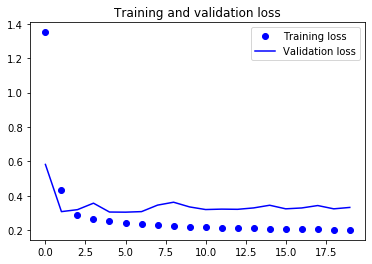

In [12]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Algunas de nuestras pérdidas de validación se acercan a la base sin aprendizaje, pero no son muy fiables. Esto demuestra el mérito de haber tenido esta base en primer lugar: resulta no ser tan fácil de superar. Nuestro sentido común ya contiene mucha información valiosa a la que un modelo de machine learning no tiene acceso.

Te podrías estar preguntado, si existe un modelo simple y de buen desempeño para pasar de los datos a los objetivos (nuestra base de sentido común), ¿por qué el modelo que estamos entrenando no lo encuentra y lo mejora? En pocas palabras: porque esta sencilla solución no es lo que nuestra configuración de entrenamiento está buscando. El espacio de los modelos en los que buscamos una solución, es decir, nuestro espacio de hipótesis, es el espacio de todas las redes de dos capas posibles. Con la configuración que hemos definido. Estas redes ya son bastante complicadas. En la búsqueda de una solución con un espacio de modelos complicados, la simple base con buen desempeño podría ser inaprendible, incluso si es técnicamente parte del espacio de hipótesis. Esto es una **limitación bastante significativa del aprendizaje automático en general**: *a menos que el algoritmo de aprendizaje esté codificado para buscar una clase específica de un modelo simple, el aprendizaje de parámetros puede a veces no encontrar una solución simple a un problema simple*.


## 6. Una primera base recurrente

Nuestro primer enfoque totalmente conectado no funcionó muy bien, pero eso no significa que el aprendizaje automático no sea aplicable a nuestro problema. El enfoque anterior consistió en aplanar primero las series temporales, lo que eliminó la noción de tiempo de los datos de entrada. En su lugar, miremos nuestros datos como lo que son: una secuencia, donde la causalidad y el orden importan. Intentaremos un modelo de procesamiento de secuencias recurrente -- debería ser el modelo perfecto para tales datos secuenciales, precisamente porque explota el ordenamiento temporal de los puntos de datos, a diferencia de nuestro primer enfoque.

En lugar de la capa `LSTM` introducida en la práctica anterior, utilizaremos la capa `GRU`, desarrollada por Cho et al. en 2014. Las capas de `GRU` (que significa "gated recurrent unit") funcionan aprovechando el mismo principio que LSTM, pero están un poco racionalizadas y por lo tanto son más baratas de ejecutar, aunque puede que no tengan tanto poder de representación como las LSTM. Este compromiso entre la costosidad computacional y el poder de representación se ve en todas partes en el aprendizaje automático.

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 81s 161ms/step - loss: 0.2988 - val_loss: 0.2714
Epoch 2/20
500/500 [==============================] - 80s 161ms/step - loss: 0.2846 - val_loss: 0.2679
Epoch 3/20
500/500 [==============================] - 80s 161ms/step - loss: 0.2789 - val_loss: 0.2649
Epoch 4/20
500/500 [==============================] - 81s 161ms/step - loss: 0.2745 - val_loss: 0.2650
Epoch 5/20
500/500 [==============================] - 80s 160ms/step - loss: 0.2684 - val_loss: 0.2605
Epoch 6/20
500/500 [==============================] - 80s 161ms/step - loss: 0.2629 - val_loss: 0.2637
Epoch 7/20
500/500 [==============================] - 80s 160ms/step - loss: 0.2572 - val_loss: 0.2668
Epoch 8/20
500/500 [==============================] - 80s 161ms/step - loss: 0.2524 - val_loss: 0.2656
Epoch 9/20
500/500 [==============================] - 81s 161ms/step - loss: 0.2475 - val_loss: 0.2704
Epoch 10/20
500/500 [==============================] - 80s 161ms/step - l

Miremos nuestros resultados:

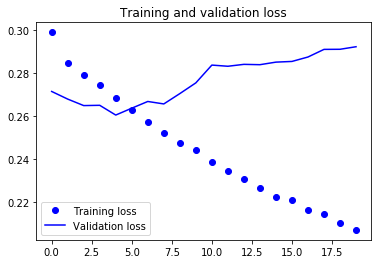

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

¡Mucho mejor! Somos capaces de superar significativamente la base del sentido común, lo que demuestra el valor del aprendizaje automático aquí, así como la superioridad de las redes recurrentes en comparación con las redes densas que aplastan la secuencia en este tipo de tareas.

Nuestra nueva validación MAE de ~0,265 (antes de que comencemos a sobreajustar significativamente) se traduce en un error absoluto medio de 2,35˚C después de la desnormalización. Eso es una sólida ganancia sobre nuestro error inicial de 2,57˚C, pero probablemente todavía tenemos un poco de margen para mejorar.

## 7. Usando recurrent dropout para contraatacar al sobreajuste

De nuestras curvas de entrenamiento y validación se deduce que nuestro modelo está sobredimensionado: las pérdidas en entrenamiento y validación empiezan a divergir considerablemente después de unas pocas épocas. Ya estás familiarizado con una técnica clásica para combatir este fenómeno: el dropout, que consiste en la puesta a cero aleatoria de las unidades de entrada de una capa para romper las correlaciones de casualidad en los datos de entrenamiento a los que está expuesta la capa. 

Sin embargo, cómo aplicar correctamente el dropout en redes recurrentes no es una cuestión trivial. Se sabe desde hace mucho tiempo que la aplicación del dropout antes de una capa recurrente dificulta el aprendizaje en lugar de ayudar con la regularización. En 2015, Yarin Gal, como parte de su tesis doctoral sobre el aprendizaje profundo bayesiano, determinó la forma correcta de utilizar el dropout con una red recurrente: se debe aplicar la misma máscara de dropout (el mismo patrón de unidades de dropout) en cada paso de tiempo, en lugar de una máscara de dropout que varíe aleatoriamente de un paso de tiempo a otro. Es más: para regularizar las representaciones formadas por las puertas recurrentes de capas como GRU y LSTM, se debe aplicar una máscara de dropout temporal constante a las activaciones internas recurrentes de la capa (una máscara de dropout "recurrente"). El uso de la misma máscara de dropout en cada paso del tiempo permite a la red propagar adecuadamente su error de aprendizaje a través del tiempo; en cambio, una máscara de dropout temporal aleatorio interrumpiría esta señal de error y sería perjudicial para el proceso de aprendizaje.

Yarin Gal hizo su investigación usando Keras y ayudó a construir este mecanismo directamente en las capas recurrentes de Keras. Cada capa recurrente en Keras tiene dos argumentos relacionados con el dropout: `dropout`, un valor tipo float que especifica la tasa de dropout para las unidades de entrada de la capa, y `recurrent_dropout`, que especifica la tasa de dropout de las unidades recurrentes. Añadamos dropout y recurrent dropouts a nuestra capa GRU y veamos cómo influyen en el sobreajuste. Debido a que las redes que se regularizan con dropout siempre tardan más en converger completamente, entrenamos a nuestra red durante el doble de épocas.

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/40
500/500 [==============================] - 93s 186ms/step - loss: 0.3436 - val_loss: 0.2758
Epoch 2/40
500/500 [==============================] - 93s 185ms/step - loss: 0.3153 - val_loss: 0.2736
Epoch 3/40
500/500 [==============================] - 93s 185ms/step - loss: 0.3104 - val_loss: 0.2698
Epoch 4/40
500/500 [==============================] - 93s 186ms/step - loss: 0.3046 - val_loss: 0.2676
Epoch 5/40
500/500 [==============================] - 93s 185ms/step - loss: 0.3013 - val_loss: 0.2689
Epoch 6/40
500/500 [==============================] - 93s 186ms/step - loss: 0.2995 - val_loss: 0.2673
Epoch 7/40
500/500 [==============================] - 93s 186ms/step - loss: 0.2966 - val_loss: 0.2677
Epoch 8/40
500/500 [==============================] - 93s 185ms/step - loss: 0.2946 - val_loss: 0.2678
Epoch 9/40
500/500 [==============================] - 93s 186

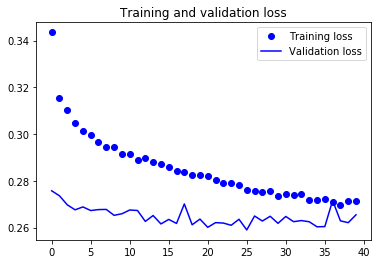

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Gran éxito, ya no estamos sobreajustando durante las primeras 30 épocas. Sin embargo, aunque tenemos puntuaciones de evaluación más estables, nuestras mejores puntuaciones no son mucho más bajas de lo que eran antes.


## 8. Apilando capas recurrentes

Dado que ya no estamos sobreajustando pero parece que hemos encontrado un cuello de botella en el rendimiento, deberíamos empezar a considerar aumentar la capacidad de nuestra red. Si recuerdas la descripción del "flujo de trabajo de aprendizaje automático universal": en general, es una buena idea aumentar la capacidad de tu red hasta que el sobreajuste se convierta en tu principal obstáculo (suponiendo que ya estés tomando medidas básicas para mitigar el sobreajuste, como el uso del dropout). Siempre y cuando no estés sobreajustando demasiado, entonces es probable que estés por debajo de capacidad de abstracción.

El aumento de la capacidad de la red se realiza normalmente aumentando el número de unidades en las capas o añadiendo más capas. El apilamiento de capas recurrentes es una forma clásica de construir redes recurrentes más potentes: por ejemplo, lo que actualmente impulsa el algoritmo de traducción de Google es una pila de siete capas grandes de LSTM, lo que es enorme.

Para poder apilar capas recurrentes una encima de otra en Keras, todas las capas intermedias deben devolver su secuencia completa de salidas (un tensor 3D) en lugar de su salida en el último paso del tiempo. Esto se hace especificando `return_sequences=True`: 

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 188s 376ms/step - loss: 0.3351 - val_loss: 0.2866
Epoch 2/40
500/500 [==============================] - 187s 374ms/step - loss: 0.3133 - val_loss: 0.2720
Epoch 3/40
500/500 [==============================] - 187s 375ms/step - loss: 0.3074 - val_loss: 0.2765
Epoch 4/40
500/500 [==============================] - 187s 374ms/step - loss: 0.3008 - val_loss: 0.2721
Epoch 5/40
500/500 [==============================] - 187s 374ms/step - loss: 0.2961 - val_loss: 0.2715
Epoch 6/40
500/500 [==============================] - 187s 374ms/step - loss: 0.2936 - val_loss: 0.2693
Epoch 7/40
500/500 [==============================] - 187s 375ms/step - loss: 0.2912 - val_loss: 0.2715
Epoch 8/40
500/500 [==============================] - 187s 374ms/step - loss: 0.2894 - val_loss: 0.2736
Epoch 9/40
500/500 [==============================] - 188s 375ms/step - loss: 0.2865 - val_loss: 0.2709
Epoch 10/40
500/500 [==============================] - 187s 374m

Veamos los resultados:

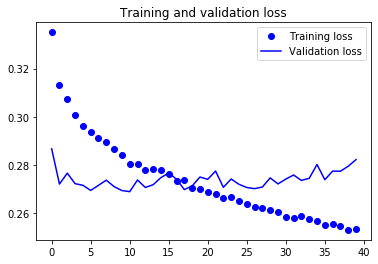

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Podemos observar que las capas añadidas mejoran nuestros resultados un poco, aunque no muy significativamente. Podemos obtener dos conclusiones de esto:

* Dado que aún no estamos sobreajustando demasiado, podemos incrementar con seguridad el tamaño de nuestras capas para buscar un poco de mejora en la pérdida de validación. Sin embargo, esto conyeva un aumento del coste computacional.
* Daado que añadir una capa no ayuda significativamente, es posible que en este punto estemos viendo una disminución de los beneficios del aumento de la capacidad de la red. 

## 9. Usando RNNs bidireccionales


La última técnica que introduciremos en esta práctica se llama "RNNs bidireccionales". Una RNN bidireccional es una variante común de RNN que puede ofrecer un mayor rendimiento que una RNN normal en determinadas tareas. Se utiliza con frecuencia en el procesamiento del lenguaje natural (PNL) - se podría decir que es la navaja suiza de aprendizaje profundo para el PNL.

Los RNNs son notablemente dependientes del orden, o dependientes del tiempo: procesan los pasos de tiempo de sus secuencias de entrada en orden, y barajando o invirtiendo los pasos de tiempo pueden cambiar completamente las representaciones que el RNN extraerá de la secuencia. Esta es precisamente la razón por la que funcionan bien en problemas donde el orden es significativo, como nuestro problema de pronóstico de temperatura. Una RNN bidireccional explota la sensibilidad del orden de las RNNs: simplemente consiste en dos RNNs regulares, como las capas GRU o LSTM con las que ya estás familiarizado, cada una de las cuales procesa la secuencia de entrada en una dirección (cronológica y anticronológicamente), y luego fusiona sus representaciones. Al procesar una secuencia en ambos sentidos, una RNN bidireccional es capaz de captar patrones que pueden haber sido pasados por alto por una RNN unidireccional.

Notablemente, el hecho de que las capas de RNN en esta práctica hayan procesado hasta ahora secuencias en orden cronológico (primero los pasos de tiempo más antiguos) puede haber sido una decisión arbitraria. Al menos, es una decisión que no hemos intentado cuestionar hasta ahora. ¿Podría ser que nuestras RNNs pudieran haber funcionado lo suficientemente bien si estuvieran procesando secuencias de entrada en orden anticronológico, por ejemplo (primero los pasos de tiempo más nuevos)? Probemos esto en la práctica y veamos qué conseguimos. Todo lo que tenemos que hacer es escribir una variante de nuestro generador de datos, donde las secuencias de entrada se revierten a lo largo de la dimensión temporal (reemplazar la última línea con `yield samples[:, ::-1, :], targets`). Entrenando la misma red de una sola capa GRU que utilizamos en el primer experimento en esta práctica, obtenemos los siguientes resultados:

In [19]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [20]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 81s 162ms/step - loss: 0.4840 - val_loss: 0.4907
Epoch 2/20
500/500 [==============================] - 81s 161ms/step - loss: 0.4455 - val_loss: 0.4862
Epoch 3/20
500/500 [==============================] - 81s 161ms/step - loss: 0.4042 - val_loss: 0.4680
Epoch 4/20
500/500 [==============================] - 80s 161ms/step - loss: 0.3672 - val_loss: 0.4572
Epoch 5/20
500/500 [==============================] - 80s 161ms/step - loss: 0.3465 - val_loss: 0.4466
Epoch 6/20
500/500 [==============================] - 81s 161ms/step - loss: 0.3277 - val_loss: 0.4606
Epoch 7/20
500/500 [==============================] - 81s 161ms/step - loss: 0.3151 - val_loss: 0.4429
Epoch 8/20
500/500 [==============================] - 80s 161ms/step - loss: 0.3008 - val_loss: 0.4461
Epoch 9/20
500/500 [==============================] - 81s 161ms/step - loss: 0.2935 - val_loss: 0.4475
Epoch 10/20
500/500 [==============================] - 81s 161ms/step - l

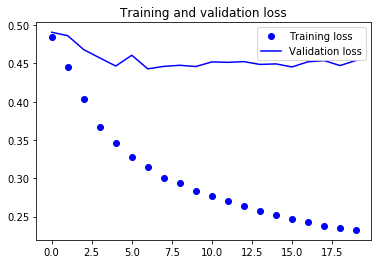

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Así que el GRU de orden inverso tiene un rendimiento muy inferior incluso a la base de sentido común, lo que indica que el procesamiento cronológico en nuestro caso es muy importante para el éxito de nuestro enfoque. Esto tiene mucho sentido: la capa de GRU subyacente normalmente recordará mejor el pasado reciente que el pasado distante, y naturalmente los puntos de datos meteorológicos más recientes son más predictivos que los puntos de datos más antiguos de nuestro problema (eso es precisamente lo que hace que la base de sentido común sea una base bastante fuerte). Por lo tanto, la versión cronológica de la capa está obligada a superar a la versión de orden inverso. Es importante destacar que esto generalmente no es cierto para muchos otros problemas, incluyendo el lenguaje natural: intuitivamente, la importancia de una palabra en la comprensión de una oración no suele depender de su posición en la oración. Intentemos el mismo truco con el ejemplo con la IMDB mediante LSTM de la práctica anterior:

In [22]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Número de palabras a considerar como características
max_features = 10000
# Cortar textos después de este número de palabras (entre las características máximas más comunes)
maxlen = 500

# Descomenta las siguientes líneas y la última de la celda en caso de obtener el error "Object arrays cannot be loaded when allow_pickle=False"
#import numpy as np
#np_load_old = np.load
#np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

# Cargar los datos
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

#np.load = np_load_old

# Invertir las secuencias
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Ampliar las secuencias
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 55s 3ms/step - loss: 0.4858 - acc: 0.7702 - val_loss: 0.5292 - val_acc: 0.7968
Epoch 2/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.3096 - acc: 0.8805 - val_loss: 0.5185 - val_acc: 0.7662
Epoch 3/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.2613 - acc: 0.9034 - val_loss: 0.3409 - val_acc: 0.8568
Epoch 4/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.2270 - acc: 0.9190 - val_loss: 0.3995 - val_acc: 0.8694
Epoch 5/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.1963 - acc: 0.9310 - val_loss: 0.3512 - val_acc: 0.8812
Epoch 6/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.1829 - acc: 0.9357 - val_loss: 0.3712 - val_acc: 0.8698
Epoch 7/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.1557 - acc: 0.9479 - val_loss: 0.3952 - val_acc:

Obtenemos un rendimiento casi idéntico al del LSTM de orden cronológico que probamos en la práctica anterior.

Por lo tanto, es notable que en un conjunto de datos de texto de este tipo, el procesamiento de orden inverso funciona tan bien como el procesamiento cronológico, lo que confirma nuestra hipótesis de que, aunque el *orden* de las palabras *importa* en la comprensión del lenguaje, no es crucial *qué orden* se utiliza. Es importante destacar que una RNN entrenada en secuencias invertidas aprenderá diferentes representaciones que una entrenada en las secuencias originales, de la misma manera que tendrías modelos mentales muy diferentes si el tiempo fluyera hacia atrás en el mundo real -- si vivieras una vida en la que murieras en tu primer día y nacieras en tu último día. En el aprendizaje automático, siempre vale la pena explotar las representaciones que son *diferentes* pero *útiles*, y cuanto más difieren, mejor: ofrecen un nuevo ángulo desde el que mirar los datos, capturando aspectos de los datos que no se han tenido en cuenta en otros enfoques, y por lo tanto pueden permitir aumentar el rendimiento en una tarea. Esta es la intuición detrás del "ensemble", por ejemplo.

Una RNN bidireccional explota esta idea para mejorar el rendimiento de las RNNs de orden cronológico: examina su secuencia de entradas en ambos sentidos, obteniendo representaciones potencialmente más ricas y capturando patrones que pueden haber sido pasados por alto sólo por la versión de orden cronológico.

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

Para instanciar una RNN bidireccional en Keras, se usa la capa `Bidirectional`, que toma como primer argumento una instancia de capa recurrente. `Bidirectional` creará una segunda instancia separada de esta capa recurrente, y utilizará una instancia para procesar las secuencias de entrada en orden cronológico y la otra para procesar las secuencias de entrada en orden inverso. Probémoslo en la tarea de análisis de sentimientos de la IMDB:

In [23]:
from keras import backend as K
K.clear_session()

In [24]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 106s 5ms/step - loss: 0.5566 - acc: 0.7190 - val_loss: 0.3629 - val_acc: 0.8610
Epoch 2/10
20000/20000 [==============================] - 106s 5ms/step - loss: 0.3289 - acc: 0.8703 - val_loss: 0.3036 - val_acc: 0.8852
Epoch 3/10
20000/20000 [==============================] - 106s 5ms/step - loss: 0.2663 - acc: 0.9017 - val_loss: 0.3586 - val_acc: 0.8794
Epoch 4/10
20000/20000 [==============================] - 105s 5ms/step - loss: 0.2234 - acc: 0.9207 - val_loss: 0.3243 - val_acc: 0.8756
Epoch 5/10
20000/20000 [==============================] - 105s 5ms/step - loss: 0.2035 - acc: 0.9265 - val_loss: 0.3420 - val_acc: 0.8844
Epoch 6/10
20000/20000 [==============================] - 106s 5ms/step - loss: 0.1755 - acc: 0.9390 - val_loss: 0.4547 - val_acc: 0.8352
Epoch 7/10
20000/20000 [==============================] - 106s 5ms/step - loss: 0.1670 - acc: 0.9406 - val_loss: 0.3505 - v

Funciona ligeramente mejor que la LSTM regular que probamos en la práctica anterior, superando el 88% de precisión de validación. También parece sobreajustar más rápido, lo que no es sorprendente ya que una capa bidireccional tiene dos veces más parámetros que una LSTM cronológica. Con un poco de regularización, la aproximación bidireccional probablemente sería un factor importante en esta tarea.

Ahora intentemos el mismo enfoque en la tarea de predicción meteorológica:

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 156s 313ms/step - loss: 0.2930 - val_loss: 0.2739
Epoch 2/40
500/500 [==============================] - 156s 311ms/step - loss: 0.2743 - val_loss: 0.2736
Epoch 3/40
500/500 [==============================] - 156s 311ms/step - loss: 0.2666 - val_loss: 0.2681
Epoch 4/40
500/500 [==============================] - 155s 311ms/step - loss: 0.2628 - val_loss: 0.2711
Epoch 5/40
500/500 [==============================] - 155s 311ms/step - loss: 0.2550 - val_loss: 0.2723
Epoch 6/40
500/500 [==============================] - 155s 311ms/step - loss: 0.2484 - val_loss: 0.2721
Epoch 7/40
500/500 [==============================] - 156s 311ms/step - loss: 0.2447 - val_loss: 0.2799
Epoch 8/40
500/500 [==============================] - 155s 311ms/step - loss: 0.2394 - val_loss: 0.2798
Epoch 9/40
500/500 [==============================] - 156s 311ms/step - loss: 0.2332 - val_loss: 0.2799
Epoch 10/40
500/500 [==============================] - 155s 311m

Funciona tan bien como la capa GRU normal. Es fácil entender por qué: toda la capacidad de predicción debe provenir de la mitad cronológica de la red, ya que se sabe que la mitad anticronológica está muy por debajo de su capacidad en esta tarea (de nuevo, porque el pasado reciente importa mucho más que el pasado lejano en este caso).


## 10. Siguientes pasos

En este punto, todavía hay muchas otras cosas que podrías intentar para mejorar el rendimiento de nuestro problema de pronóstico del tiempo:

* Ajusta el número de unidades en cada capa recurrente en la configuración apilada. Las opciones actuales son en gran medida arbitrarias y, por lo tanto, probablemente subóptimas.
* Ajusta la velocidad de aprendizaje utilizando como optimizador `RMSprop`.
* Intenta usar capas de `LSTM` en lugar de capas de `GRU`.
* Intenta usar un regresor densamente conectado más grande encima de las capas recurrentes, es decir, una capa `Dense` más grande o incluso una pila de capas `Dense`.
* No te olvides de ejecutar eventualmente los modelos de mejor rendimiento (en términos de validación MAE) en el conjunto de prueba. Empieza al menos a desarrollar arquitecturas que se sobreajusten al conjunto de validación.   

Como de costumbre: el aprendizaje profundo es más un arte que una ciencia, y aunque podemos proporcionar directrices sobre lo que es probable que funcione o no en un problema dado, en última instancia cada problema es único y tendrás que tratar de evaluar diferentes estrategias empíricamente. Actualmente no hay ninguna teoría que nos diga de antemano con precisión lo que debe hacer uno para resolver un problema de forma óptima. Debes probar e iterar.


## 11. Concluyendo

Esto es lo que deberías haber aprendido en esta práctica:

* Al abordar un nuevo problema, es bueno establecer primero bases de sentido común como referencia métrica de tu elección. Si no tienes una base que batir, no puedes decir si estás haciendo algún progreso real.
* Prueba modelos sencillos antes que los costosos, para justificar el gasto adicional. A veces un modelo simple resultará ser tu mejor opción.
* En los datos en los que el ordenamiento temporal es importante, las redes recurrentes encajan perfectamente y superan fácilmente a los modelos que primero aplastan los datos temporales.
* Para utilizar dropout con redes recurrentes, se debe utilizar una máscara de tiempo constante y una máscara de dropout recurrente. Esto está incorporado en las capas recurrentes de Keras, así que todo lo que tienes que hacer es usar los argumentos `dropout` y `recurrent_dropout` de las capas recurrentes.
* Las RNNs apiladas proporcionan más poder de representación que una sola capa de RNN. También son mucho más costosos y, por lo tanto, no siempre valen la pena. Si bien ofrecen claras ventajas sobre problemas complejos (por ejemplo, la traducción automática), es posible que no siempre sean relevantes para problemas más pequeños y sencillos.
* Los RNNs bidireccionales, que miran una secuencia en ambos sentidos, son muy útiles en problemas de procesamiento de lenguaje natural. Sin embargo, no tendrán un buen desempeño en los datos de secuencias en los que el pasado reciente es mucho más informativo que el comienzo de la secuencia.

Hay dos conceptos importantes que no trataremos en detalle aquí: la "atención" recurrente y el enmascaramiento de secuencias. Ambos tienden a ser especialmente relevantes para el procesamiento del lenguaje natural, y no son particularmente aplicables a nuestro problema de pronóstico de temperatura.